In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Lectura de datos desde .csv

In [2]:
#Lectura de plantas y creación de lista con DataFrames

directory_path = "C:\\Users\\franc\\OneDrive\\Documentos\\VScode\\Github\\Franico-proyecto\\dataset\\"

files_names = [file for file in os.listdir(directory_path)]

#quito la extensión
names = []
for i in files_names:
    names.append(i[:-4])

df_list = []
size_list = []

size = pd.read_excel('size_plantas.xlsx', engine='openpyxl')


for name, j in zip(files_names, names):
    df_list.append(pd.read_csv(directory_path + name, encoding = 'latin1'))

    fila = size[size["nombre_planta"] == j]
    
    size_list.append(fila["size"].iloc[0])


Funciones útiles a utilizar

In [3]:
#Funciones a utilizar

def extract_samples(dataframe, cutting = 1):
    '''Función para extraer los vectores de generación para cada dataframe'''

    values = dataframe["muestra"].unique()
    samples, labels, vectors = [], [], []

    for i in values:
        l_df = dataframe[dataframe["muestra"] == i]
        if np.isnan(l_df["generacion"].values).any() == True:
            continue

        v_gen = l_df["generacion"].values
        v_clip = l_df["clipping"].values
        v_poa = l_df["poa"].values

        #Quitar negativos
        v_gen = [0 if x < 0 else x for x in v_gen]
        v_poa = [0 if x < 0 else x for x in v_poa]

        maximo = max( max(v_gen), max(v_poa))

        for i in range(cutting):
            v_gen = v_gen[12:-4]
            v_clip = v_clip[12:-4]
            v_poa = v_poa[12:-4]

        if np.isnan(v_gen).any() == True:
            continue
        if np.isnan(v_poa).any() == True:
            continue

       
        vectors.append([v_gen, v_poa])    
        v_gen = v_gen/maximo
        v_poa = v_poa/maximo

        samples.append([v_gen, v_poa])
        labels.append(v_clip)

    return samples, labels, vectors


def error_threshold(predict_vector, test_label, error_tolerance):
    '''Función para obtener vectores predichos con cierta cantidad de errores'''

    error = []
    error_vector = []

    for i,j in zip(predict_vector, test_label):
        if (i != j).any():
            error.append([i,j])

        if list(i == j).count(False) == error_tolerance:
            error_vector.append([i, j])
    
    return error, error_vector


Creación de dataset y vectores de entrenamiento y test

In [ ]:
n_vectores = []
label = []
vectores = []

for d_frame in df_list:
    result = extract_samples(d_frame, cutting = 1)
    for i, j,k in zip(result[0], result[1], result[2]):
        n_vectores.append(i)
        label.append(j)
        vectores.append(k)

In [44]:
# Guardar las variables en un archivo
with open("variables.pkl", "wb") as archivo:
    pickle.dump((n_vectores, label, vectores), archivo)

Cargar Datos

In [5]:
with open("C:\\Users\\franc\\OneDrive\\Documentos\\VScode\\Github\\Franico-proyecto\\code\\variables.pkl", "rb") as archivo:
    normalized_vectors, label, vectors = pickle.load(archivo)

KeyboardInterrupt: 

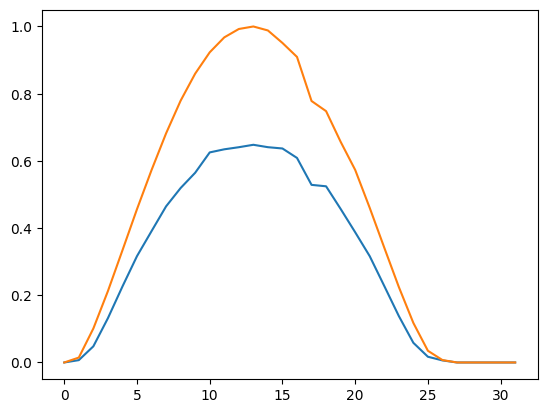

In [6]:
c = range(0, len(n_vectores))

ruta_guardado = "C:\\Users\\franc\\OneDrive\\Documentos\\VScode\\Github\\Franico-proyecto\\models\\Graficos\\"

for v, n in zip(n_vectores, c):
    plt.plot(v[0])
    plt.plot(v[1])
    nombre = str(n) + ".png"
    plt.savefig(ruta_guardado + nombre)

    plt.clf()
